# Wrangle and Analyze Data 

## Table of Contents
- [Introduction](#intro)
- [Gather](#gather)
- [Assess](#assess)
    - [Summary](#summary)
- [Clean](#clean)
- [Storing](#storing)
- [Analyze](#analyze)
- [Resources](#resources)

<a id='intro'></a>
## Introduction
This notbook contains the wrangeling process of three datasets gathered from different sources. The wrangeling process is devided into three steps: gather, assess and clean. In the gather step I will uses diffent ways to get data, than I will assess the data visually and programmatically and create a list with all the anomalies in the data. These anomalies will be taken care of in the cleaning step. In the last section I will use the cleaned data to create some insights.


<a id='gather'></a>
## Gather
Data will be gathered from three different sources:
1. Twitter archived data from WeRateDogs Twitter archive
2. Additional data queried from the Twitter API
3. Dog type predictions from the pictures in the WeRateDogs archive from a neural network

In [125]:
#imports
import pandas as pd
import numpy as np
import json
import os
import tweepy
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [4]:
r = requests.get(url)

In [5]:
with open('image-predictions.tsv', mode ='wb') as file:
    file.write(r.content)

In [6]:
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

I didn't use Tweepy so here is the code from the twitter-api.py. I added some comments to show that I understand the following code:

In [ ]:
# realated imports for accessing Twitter API
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer #show time of processes

# the keys are hidden, as it is standard practice for APIs and public code 
# usually the keys are stored in a secret python file with is only accesible for the owner
# to get the keys we have to register a new application in Twitter developer
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

# creating an OAuthHandler instance
auth = OAuthHandler(consumer_key, consumer_secret)
# equipping the OAuthHandle with the acces toek
auth.set_access_token(access_token, access_secret)
# get access to Twitter API througu tweepy
api = tweepy.API(auth, wait_on_rate_limit=True)

# get the tweet id's to query the twitter API in the next step
tweet_ids = twitter_archive.tweet_id.values 
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer() # initiate timer function for the start

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile) # write a object into a JSON formatted data file to a fp(file pointer: 'outfile')
            outfile.write('\n') #writes a new line for each 
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass

end = timer() # end the timer
print(end - start)
print(fails_dict)

In [7]:
# lines=True from https://stackoverflow.com/questions/30088006/loading-a-file-with-more-than-one-line-of-json-into-pandas
# to prevent Trailing data error
twitter_api_data = pd.read_json('tweet-json.txt', lines=True)

In [8]:
# only use the relevant columns
twitter_api_data = twitter_api_data[['id', 'retweet_count', 'favorite_count']]

<a id='assess'></a>
## Assess
<b>Visual Assessment</b> with .head()/tail()/info()

In [9]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
image_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [14]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
twitter_api_data.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [16]:
twitter_api_data.tail()

,id,retweet_count,favorite_count
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132
2353,666020888022790149,532,2535


In [17]:
twitter_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.3 KB


<b>Programmatic assessment</b> using pandas functions to dive deeper into the dataframes

In [18]:
# from visual assessment: 181 retweets
twitter_archive[twitter_archive['retweeted_status_id'].notna()]
# text shows RT, which means 'retweet'

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [19]:
# check values for the numerator used for rating dogs
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [20]:
# create a list from the values
unique_numerators = twitter_archive['rating_numerator'].value_counts().index.values
# only extract strange numerators with low frequency (<10)
# since the output is ordered by value counts, we can query with indexing
strange_numerators = unique_numerators[12:]
strange_numerators

array([   1,    2,  420,    0,   15,   75,   80,   20,   24,   26,   44,
         50,   60,  165,   84,   88,  144,  182,  143,  666,  960, 1776,
         17,   27,   45,   99,  121,  204])

In [21]:
# use the strange numerators to get the index values of each numerator
strange_numerator_index = twitter_archive.loc[twitter_archive['rating_numerator'].isin(strange_numerators)].index.values
#inspiration from: https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values
strange_numerator_index

array([  55,  188,  189,  285,  290,  291,  313,  315,  340,  433,  516,
        605,  695,  763,  902,  979, 1016, 1120, 1202, 1228, 1254, 1274,
       1351, 1433, 1446, 1634, 1635, 1663, 1712, 1761, 1764, 1779, 1843,
       1869, 1920, 1940, 2038, 2074, 2079, 2091, 2237, 2246, 2261, 2310,
       2326, 2335, 2338, 2349])

In [22]:
#print the text from the index of the numerators and the Rating
for value in strange_numerator_index:
    print(f'{value}: {twitter_archive["text"][value]}, Rating: {twitter_archive["rating_numerator"][value]}/{twitter_archive["rating_denominator"][value]}')
# go through each line to identify problematic data

55: @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s, Rating: 17/10
188: @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research, Rating: 420/10
189: @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10, Rating: 666/10
285: RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI, Rating: 15/10
290: @markhoppus 182/10, Rating: 182/10
291: @bragg6of8 @Andy_Pace_ we are still looking for the first 15/10, Rating: 15/10
313: @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho, Rating: 960/0
315: When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag, Rating: 0/10
340: RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t

In [23]:
# 'RT' can be ignored because thy get droped 
# tweets starting with '@' get also droped, since they aren't origial (replies)
# 516: no rating provided
# 695: float as numerator -> there are more (e.g.: 763)
# 1202: (11/10)
# 2335: 9/10

In [24]:
# 695 has a float as the numerator, which means there could be more that are not properly recorded in the 
# numerating column, since it is formatted as int.
# using regular expression to filter through the text column
twitter_archive[twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator', 'rating_denominator']]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator,rating_denominator
45,This is Bella. She hopes her smile made you sm...,5,10
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
1689,I've been told there's a slight possibility he...,5,10
1712,Here we have uncovered an entire battalion of ...,26,10


In [25]:
float_numerator = [45, 340, 695, 763, 1689, 1712]

In [26]:
for value in float_numerator:
    print(f'{value}: {twitter_archive["text"][value]}')

45: This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
340: RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
695: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
763: This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1689: I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace
1712: Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [27]:
# 45: 13.5/10
# 695: 9.75/10 
# 763: 11.27/10
#1689: 9.5/10 -> this is a reply
#1712: 11.26/10

In [28]:
# do the same with denominators
twitter_archive['rating_denominator'].value_counts()
# 10 seems to be the most used denominator

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [29]:
unique_denominators = twitter_archive['rating_denominator'].value_counts().index.values
strange_denuminators = unique_denominators[1:]
strange_denuminators

array([ 11,  50,  80,  20,   2,  16,  40,  70,  15,  90, 110, 120, 130,
       150, 170,   7,   0])

In [30]:
strange_denuminator_index = twitter_archive.loc[twitter_archive['rating_denominator'].isin(strange_denuminators)].index.values
strange_denuminator_index

array([ 313,  342,  433,  516,  784,  902, 1068, 1120, 1165, 1202, 1228,
       1254, 1274, 1351, 1433, 1598, 1634, 1635, 1662, 1663, 1779, 1843,
       2335])

In [31]:
#print the text from the index of the numerators 
for value in strange_denuminator_index:
    print(f'{value}: {twitter_archive["text"][value]}, Rating: {twitter_archive["rating_numerator"][value]}/{twitter_archive["rating_denominator"][value]}')
# go through each line to identify problematic data

313: @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho, Rating: 960/0
342: @docmisterio account started on 11/15/15, Rating: 11/15
433: The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd, Rating: 84/70
516: Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx, Rating: 24/7
784: RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…, Rating: 9/11
902: Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE, Rating: 165/150
1068: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ, Rating: 9/11
1120: Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet

In [32]:
# list with false denuminators
#1068: (14/10)
#1165: (13/10)
#1662: (10/10)

In [33]:
twitter_archive['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Kawhi        1
Dotsy        1
Marvin       1
Grady        1
Yoda         1
Name: name, Length: 957, dtype: int64

In [34]:
twitter_archive['name'].value_counts().sample(20)
# it seems that all 'real' dog names are capitalized. 

Maddie       4
Wiggles      1
mad          2
Zuzu         1
Vinnie       1
Willie       1
River        1
Wyatt        3
Socks        1
Kody         1
Stella       1
Bonaparte    1
Griswold     1
Rhino        1
Damon        1
Cermet       1
Dakota       2
Snoop        1
Suki         1
Barney       1
Name: name, dtype: int64

In [35]:
image_predictions['tweet_id'].duplicated().sum()
# no duplicates in tweet id

0

In [36]:
image_predictions['jpg_url'].duplicated().sum()
# 66 duplicates in jpg_url

66

In [37]:
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [38]:
image_predictions.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [39]:
image_predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [40]:
# check if all predictions can be false
image_predictions.query('p1_dog == False' and 'p2_dog == False' and 'p3_dog == False')
# 576 predictions couldn't identify a dog

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2063,889880896479866881,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog,0.377417,True,Labrador_retriever,0.151317,True,muzzle,0.082981,False
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


In [41]:
twitter_api_data['id'].duplicated().sum()

0

<a id='summary'></a>
#### Quality

<b>twitter_archive</b>
- 181 retweets -> we only want original ratings
- 78 replies -> we only want original ratings
- tweet_id is an integer
- a few irrelevant columns
- timestamp is a string and not a datetime object
- extracted rating is wrong sometimes
- inconsistent rating denominators (!= 10) and outlieres for numerators
- 'name' column contains strings that aren't related to a dog names

<b>twitter_api_data</b>
- id is an integer

<b>image_predictions</b>
- 66 duplicates in column jpg_url
- a few irrelevant columns (3 predictions)
- dog types predictions are inconsistent in terms of capitalization


#### Tidiness

<b>twitter_archive</b>
- the dog stages variable is split into 4 columns (doggo, floofer, pupper & puppo)

<b>general</b>
- all dataframes are part of the same observational unit so they should be merged into one dataframe

<a id='clean'></a>
## Clean

In [42]:
# first creat a copy from for each dataframe
twitter_archive_clean = twitter_archive.copy()
twitter_api_data_clean = twitter_api_data.copy()
image_predictions_clean = image_predictions.copy()

### Quality

#### twitter_archive

<b>1. Drop replies and retweets</b>

##### Define:
drop the associated rows which indicates that the tweet is a retweet or reply ('in_reply_to....' & 'retweeted_statis_....). Use isnull() to find the null values and us this as a mask to extract only the null values from the relevant columns. Code From:
https://stackoverflow.com/questions/25430995/keeping-nan-values-and-dropping-nonmissing-values


##### Code:

In [43]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id'].isnull()]

##### Test:

In [44]:
len(twitter_archive) - len(twitter_archive_clean)
# should return 78

78

##### Code:

In [45]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

##### Test:

In [46]:
len(twitter_archive) - len(twitter_archive_clean) - 78
# should return 181

181

<b>2. Drop irrelevant columns</b>

##### Define:
drop all unimportant columns to have a 'simpler' dataframe

##### Code:

In [47]:
columns_drops = ['source', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 
                 'retweeted_status_timestamp', 'expanded_urls']

In [48]:
twitter_archive_clean.drop(columns_drops, 1, inplace=True)

##### Test:

In [49]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None


<b>3. Twitter id is an integer</b>

##### Define:
since we wont make any calculations with this column it should be a string - transform 'tweet_id' to string

##### Code:

In [50]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_api_data_clean['id'] = twitter_api_data_clean['id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

##### Test:

In [51]:
twitter_archive_clean['tweet_id'].dtypes
# dtype('O') stands for object, which is a string in pandas

dtype('O')

In [52]:
twitter_api_data_clean['id'].dtypes

dtype('O')

In [53]:
image_predictions_clean['tweet_id'].dtypes

dtype('O')

<b>4. Timestamp to Datetime object</b>

##### Define:
to use the timestamp column effectively for further analysis it needs to be transfromed to a datetime object. The datetime data is provided in the following format = Y-m-d H:M:S timezone.

##### Code:

In [54]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'], format="%Y-%m-%d %H:%M:%S")

##### Test:

In [55]:
twitter_archive_clean['timestamp'].dtypes
# column contains the datetime and the timezone

datetime64[ns, UTC]

<b>5. Issues with inaccurate ratings</b>

##### Define:
in some cases the ratings aren't correctly extracted from the tweets. Some have decimalas and others are just false. Incorrect ratings will be transformed manually. 

In [56]:
# 516: no rating provided - can be dropped
# 1202: 11/10
# 2335: 9/10
# 45: 13.5/10
# 695: 9.75/10 
# 763: 11.27/10
#1712: 11.26/10
#1068: 14/10
#1165: 13/10
#1662: 10/10

##### Code:

In [57]:
twitter_archive_clean.drop(516, 0, inplace=True)

In [58]:
# set rating columns as float
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean[['rating_numerator','rating_denominator']].astype(float)

In [59]:
twitter_archive_clean.loc[1202, 'rating_numerator'] = 11
twitter_archive_clean.loc[1202, 'rating_denominator'] = 10

twitter_archive_clean.loc[2335, 'rating_numerator'] = 9
twitter_archive_clean.loc[2335, 'rating_denominator'] = 10

twitter_archive_clean.loc[45, 'rating_numerator'] = 13.5
twitter_archive_clean.loc[45, 'rating_denominator'] = 10

twitter_archive_clean.loc[695, 'rating_numerator'] = 9.75
twitter_archive_clean.loc[695, 'rating_denominator'] = 10

twitter_archive_clean.loc[763, 'rating_numerator'] = 11.27
twitter_archive_clean.loc[763, 'rating_denominator'] = 10

twitter_archive_clean.loc[1712, 'rating_numerator'] = 11.26
twitter_archive_clean.loc[1712, 'rating_denominator'] = 10

twitter_archive_clean.loc[1068, 'rating_numerator'] = 14
twitter_archive_clean.loc[1068, 'rating_denominator'] = 10

twitter_archive_clean.loc[1165, 'rating_numerator'] = 13
twitter_archive_clean.loc[1165, 'rating_denominator'] = 10

twitter_archive_clean.loc[1662, 'rating_numerator'] = 13
twitter_archive_clean.loc[1662, 'rating_denominator'] = 10

In [60]:
rating_change = [1202,2335,45,695,763,1712,1068,1165,1662]

##### Test:

In [61]:
with pd.option_context('max_colwidth', 200):
    display(twitter_archive_clean.loc[rating_change][['text', 'rating_numerator', 'rating_denominator']])
# https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe

,text,rating_numerator,rating_denominator
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11.00,10.0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9.00,10.0
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14.00,10.0
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13.00,10.0
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,13.00,10.0


<b>6. inconsistent rating denominators and outliers for numinators</b>

##### Define:
get denominators unequal to 10 and numeratots higer than 14, make adjustments when possible and drop rows to get consistent rating, since outlieres or inconsistent denominators would skew statistics like the mean. Than drop rating_denominator and rename rating_numerator to rating_out_of_10

##### Code:

In [62]:
inconsistent_rating = twitter_archive_clean.query('rating_denominator != 10' and 'rating_numerator > 14')
inconsistent_rating
# it seems that the high rating denominator is due to the fact that there were multiple dogs in one picture 
# there are two ratings that have 10 as the denominator but really high numerators 

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the flo...,84.0,70.0,None,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door......,165.0,150.0,None,None,None,None,None
979,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af....,1776.0,10.0,Atticus,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved sq...,204.0,170.0,this,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0,None,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49+00:00,Here's a brigade of puppers. All look very pre...,80.0,80.0,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08+00:00,"From left to right:\nCletus, Jerome, Alejandro...",45.0,50.0,None,None,None,None,None
1351,704054845121142784,2016-02-28 21:25:30+00:00,Here is a whole flock of puppers. 60/50 I'll ...,60.0,50.0,a,None,None,None,None
1433,697463031882764288,2016-02-10 16:51:59+00:00,Happy Wednesday here's a bucket of pups. 44/40...,44.0,40.0,None,None,None,None,None
1635,684222868335505415,2016-01-05 04:00:18+00:00,Someone help the girl is being mugged. Several...,121.0,110.0,None,None,None,None,None


In [63]:
print(twitter_archive['text'][979]) # dog in front of the USA flag posted on the 4th July (now the rating makes sense)
print(twitter_archive['text'][2074]) # it is a picture of Snoop Dog

This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY


In [64]:
drop_rating = inconsistent_rating.index.values
drop_rating

array([ 433,  902,  979, 1120, 1228, 1254, 1274, 1351, 1433, 1635, 1779,
       1843, 2074])

In [65]:
twitter_archive_clean.drop(index=drop_rating, inplace=True)

In [66]:
twitter_archive_clean.drop('rating_denominator', 1, inplace=True)

In [67]:
twitter_archive_clean.rename(columns={'rating_numerator': 'rating_out_of_10'}, inplace=True)

##### Test:

In [68]:
twitter_archive_clean.query('rating_out_of_10 > 14')
# should be an empty output

,tweet_id,timestamp,text,rating_out_of_10,name,doggo,floofer,pupper,puppo


<b>7. 'name' column contains strings that aren't related to a dog name</b>

##### Define:
transfrom non-related dog names into strings

##### Code:

In [69]:
twitter_archive_clean['name'] = twitter_archive_clean.name.str.replace('^[a-z]+', 'None')

##### Test:

In [70]:
twitter_archive_clean['name'].value_counts()

None        695
Lucy         11
Charlie      11
Oliver       10
Cooper       10
           ... 
Ace           1
Moofasa       1
Timber        1
Einstein      1
Yoda          1
Name: name, Length: 930, dtype: int64

#### Image predictions

<b>8. drop dubplicates</b>

##### Define:
drop 66 dubplicates in the jpg_url column

##### Code:

In [71]:
image_predictions_clean.drop_duplicates('jpg_url', inplace=True)

#### Test:

In [72]:
len(image_predictions) - len(image_predictions_clean)
# should return 66 

66

<b>9. creat column for dog prediction and confidence level </b>

##### Define:
We don't need three predictions and the corresponding confidence levels - reduce to one column for prediction and one for the corresponding confidence leve. Create empty lists and define a function which appends the prediction and confidence level when the prediction is actually a breed of dog. Add the lists to the dataframe.

##### Code:

In [73]:
dog_type = []
confidence_level = []

In [74]:
# creat function
def prediction(image_prediction_clean):
    if image_prediction_clean['p1_dog'] == True:
        dog_type.append(image_prediction_clean['p1'])
        confidence_level.append(image_prediction_clean['p1_conf'])
    elif image_prediction_clean['p2_dog'] == True:
        dog_type.append(image_prediction_clean['p2'])
        confidence_level.append(image_prediction_clean['p2_conf'])
    elif image_prediction_clean['p3_dog'] == True:
        dog_type.append(image_prediction_clean['p3'])
        confidence_level.append(image_prediction_clean['p3_conf'])
    # include the else statement, because we identified 576 cases where no dog was identified from the neural network
    else:
        dog_type.append('Error')
        confidence_level.append('Error')

In [75]:
# apply function
image_predictions_clean.apply(prediction, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
2070    None
2071    None
2072    None
2073    None
2074    None
Length: 2009, dtype: object

In [76]:
image_predictions_clean['dog_type'] = dog_type
image_predictions_clean['confidence_level'] = confidence_level

##### Test:

In [77]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,confidence_level
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311


### Tidiness

#### twitter_archive

<b>10. 4 columns for dog stages</b>

##### Define:
extract the dog stages from the text with regular expressions, transform into a categorical variable for better analyses capability and finally drop the four columns 

In [78]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id            2083 non-null object
timestamp           2083 non-null datetime64[ns, UTC]
text                2083 non-null object
rating_out_of_10    2083 non-null float64
name                2083 non-null object
doggo               2083 non-null object
floofer             2083 non-null object
pupper              2083 non-null object
puppo               2083 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 162.7+ KB


In [79]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [80]:
twitter_archive_clean['dog_stage'].value_counts()

pupper     235
doggo       79
puppo       29
floofer      4
Name: dog_stage, dtype: int64

In [81]:
twitter_archive_clean['dog_stage'].astype('category')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2351    NaN
2352    NaN
2353    NaN
2354    NaN
2355    NaN
Name: dog_stage, Length: 2083, dtype: category
Categories (4, object): [doggo, floofer, pupper, puppo]

In [82]:
twitter_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

##### Test:

In [83]:
twitter_archive_clean['dog_stage']
# shpuld be an object = dtype('O')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2351    NaN
2352    NaN
2353    NaN
2354    NaN
2355    NaN
Name: dog_stage, Length: 2083, dtype: object

In [84]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,text,rating_out_of_10,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN


#### General

<b>11. Create one dataframe</b>

##### Define:
inner join twitter_achrive with twitter_api_data and image_prediction on twitter id. Column 'id' in twitter_api_data needs to be changed to 'tweet_id'. Drop irrelevant columns and order the dataframe to enhance readability.

##### Code:

In [85]:
twitter_api_data_clean.rename(columns={'id': 'tweet_id'}, inplace=True)

In [86]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id            2083 non-null object
timestamp           2083 non-null datetime64[ns, UTC]
text                2083 non-null object
rating_out_of_10    2083 non-null float64
name                2083 non-null object
dog_stage           347 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 113.9+ KB


In [87]:
twitter_api_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [88]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 14 columns):
tweet_id            2009 non-null object
jpg_url             2009 non-null object
img_num             2009 non-null int64
p1                  2009 non-null object
p1_conf             2009 non-null float64
p1_dog              2009 non-null bool
p2                  2009 non-null object
p2_conf             2009 non-null float64
p2_dog              2009 non-null bool
p3                  2009 non-null object
p3_conf             2009 non-null float64
p3_dog              2009 non-null bool
dog_type            2009 non-null object
confidence_level    2009 non-null object
dtypes: bool(3), float64(3), int64(1), object(7)
memory usage: 194.2+ KB


In [89]:
twitter_data_comp = pd.merge(twitter_api_data_clean, twitter_archive_clean, how='inner', on='tweet_id')

In [90]:
twitter_data_comp = pd.merge(twitter_data_comp, image_predictions_clean, how='inner', on='tweet_id')

In [91]:
twitter_data_comp.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'timestamp', 'text',
       'rating_out_of_10', 'name', 'dog_stage', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_type', 'confidence_level'],
      dtype='object')

In [92]:
# drop unrelevnat columns
twitter_data_comp.drop(columns=['img_num' ,'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

In [93]:
twitter_data_comp.head(1)

,tweet_id,retweet_count,favorite_count,timestamp,text,rating_out_of_10,name,dog_stage,jpg_url,dog_type,confidence_level
0,892420643555336193,8853,39467,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Error,Error


In [94]:
twitter_data_comp.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'timestamp', 'text',
       'rating_out_of_10', 'name', 'dog_stage', 'jpg_url', 'dog_type',
       'confidence_level'],
      dtype='object')

In [95]:
# reorder columns 
twitter_data_comp.reindex(columns=['tweet_id', 'timestamp', 'jpg_url', 'text', 'retweet_count', 'favorite_count', 'rating_out_of_10', 'name', 'dog_stage', 'dog_type', 'confidence_level'])
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns 

,tweet_id,timestamp,jpg_url,text,retweet_count,favorite_count,rating_out_of_10,name,dog_stage,dog_type,confidence_level
0,892420643555336193,2017-08-01 16:23:56+00:00,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,This is Phineas. He's a mystical boy. Only eve...,8853,39467,13.0,Phineas,NaN,Error,Error
1,892177421306343426,2017-08-01 00:17:27+00:00,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,This is Tilly. She's just checking pup on you....,6514,33819,13.0,Tilly,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,This is Archie. He is a rare Norwegian Pouncin...,4328,25461,12.0,Archie,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51+00:00,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,This is Darla. She commenced a snooze mid meal...,8964,42908,13.0,Darla,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24+00:00,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,This is Franklin. He would like you to stop ca...,9774,41048,12.0,Franklin,NaN,basset,0.555712
...,...,...,...,...,...,...,...,...,...,...,...
1952,666049248165822465,2015-11-16 00:24:50+00:00,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Here we have a 1949 1st generation vulpix. Enj...,41,111,5.0,None,NaN,miniature_pinscher,0.560311
1953,666044226329800704,2015-11-16 00:04:52+00:00,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,This is a purebred Piers Morgan. Loves to Netf...,147,311,6.0,None,NaN,Rhodesian_ridgeback,0.408143
1954,666033412701032449,2015-11-15 23:21:54+00:00,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,Here is a very happy pup. Big fan of well-main...,47,128,9.0,None,NaN,German_shepherd,0.596461
1955,666029285002620928,2015-11-15 23:05:30+00:00,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,This is a western brown Mitsubishi terrier. Up...,48,132,7.0,None,NaN,redbone,0.506826


Test:

In [96]:
twitter_data_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1957 entries, 0 to 1956
Data columns (total 11 columns):
tweet_id            1957 non-null object
retweet_count       1957 non-null int64
favorite_count      1957 non-null int64
timestamp           1957 non-null datetime64[ns, UTC]
text                1957 non-null object
rating_out_of_10    1957 non-null float64
name                1957 non-null object
dog_stage           316 non-null object
jpg_url             1957 non-null object
dog_type            1957 non-null object
confidence_level    1957 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(7)
memory usage: 183.5+ KB


<a id='storing'></a>
## Storing Wrangled Data

In [97]:
twitter_data_comp.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
## Analyze
- [What is the Distribution of the Rating?](#dist)
- [What is the most rated dog breed?](#most)
- [What is the best and worst rated dog breed?](#best)
- [What are the top 5 dog names?](#names)
- [Are retweet count and favorite count related?](#related)

In [98]:
twitter_data = pd.read_csv('twitter_archive_master.csv')

In [99]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 11 columns):
tweet_id            1957 non-null int64
retweet_count       1957 non-null int64
favorite_count      1957 non-null int64
timestamp           1957 non-null object
text                1957 non-null object
rating_out_of_10    1957 non-null float64
name                1957 non-null object
dog_stage           316 non-null object
jpg_url             1957 non-null object
dog_type            1957 non-null object
confidence_level    1957 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 168.3+ KB


<a id='dist'></a>
### What is the Distribution of the Rating?

In [124]:
twitter_data['rating_out_of_10'].value_counts().sort_index()

0.00       1
1.00       4
2.00       9
3.00      19
4.00      15
5.00      32
6.00      32
7.00      51
8.00      95
9.00     150
9.75       1
10.00    417
11.00    393
11.26      1
11.27      1
12.00    446
13.00    255
13.50      1
14.00     34
Name: rating_out_of_10, dtype: int64

In [123]:
twitter_data['rating_out_of_10'].describe()

count    1957.000000
mean       10.546643
std         2.170956
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_out_of_10, dtype: float64

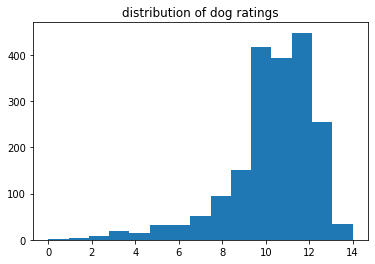

In [149]:
plt.hist(twitter_data['rating_out_of_10'], bins=15)
plt.title('distribution of dog ratings');

<b>Most dogs are rated in the area of 9 to 13, with the average rating of 10.55 in the range from 0 to 14</b>

<a id='most'></a>
### What is the most rated dog breed?

In [181]:
twitter_data['dog_type'].value_counts()

Error                   302
golden_retriever        154
Labrador_retriever      103
Pembroke                 94
Chihuahua                90
                       ... 
silky_terrier             1
Bouvier_des_Flandres      1
standard_schnauzer        1
Japanese_spaniel          1
Irish_wolfhound           1
Name: dog_type, Length: 114, dtype: int64

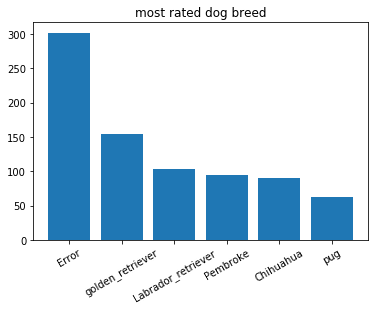

In [183]:
plt.bar(twitter_data['dog_type'].value_counts().index[:6], height=twitter_data['dog_type'].value_counts().values[:6])
plt.xticks(rotation=30)
plt.title('most rated dog breed');

<b>the most rated dog breed is the golden retriever</b>

<a id='best'></a>
### What is the best and worst rated dog breed?

In [139]:
twitter_data.groupby(by='dog_type').mean()['rating_out_of_10'].sort_values()

dog_type
Japanese_spaniel                5.000000
soft-coated_wheaten_terrier     8.166667
Walker_hound                    9.000000
Scotch_terrier                  9.000000
Error                           9.003311
                                 ...    
Border_terrier                 12.142857
Tibetan_mastiff                12.250000
briard                         12.333333
Saluki                         12.500000
Bouvier_des_Flandres           13.000000
Name: rating_out_of_10, Length: 114, dtype: float64

<b>The best rated dog breed is a the Bouvier des Flandres and the worst is the Japanese Spaniel</b>

In [145]:
# imports to show an image from a webpage 
from IPython.display import Image
from IPython.core.display import HTML 
print('Here is a random picture of a Japanese Spaniel:')
Image(url= "https://animals.net/wp-content/uploads/2018/08/Japanese-Chin-5-650x425.jpg")
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o

Here is a random picture of a Japanese Spaniel:


In [146]:
print('Here is a random picture of a Bouvier des Flandres:')
Image(url= "https://www.dehunderassen.de/uploads/thumbs/720x568-resize/dog/626/bouvier-des-flandres-13489.jpg")

Here is a random picture of a Bouvier des Flandres:


<a id='names'></a>
### What are the top 5 dog names?

In [166]:
twitter_data['name'].value_counts().head(6)

None       610
Charlie     11
Cooper      10
Oliver      10
Lucy        10
Tucker       9
Name: name, dtype: int64

<b>The top 5 dod names in this dataset are: Charlie, Cooper, Oliver, Lucy and Tucker</b>

<a id='related'></a>
### Are retweet count and favorite count related?

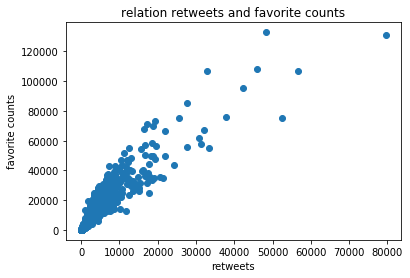

In [160]:
plt.scatter(twitter_data['retweet_count'], twitter_data['favorite_count'])
plt.xlabel('retweets')
plt.ylabel('favorite counts')
plt.title('relation retweets and favorite counts');

In [158]:
twitter_data['retweet_count'].corr(twitter_data['favorite_count'])

0.9130503769057876

<b>Yes, retweet and favourite count are related to each other. In fact they have a strong positive corrleation of r = 0.91, which means that retweet count gets higher with higher favorite count and vice versa.</b>

<a id='resources'></a>
## Resources
- https://stackoverflow.com/questions/30088006/loading-a-file-with-more-than-one-line-of-json-into-pandas
- https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values
- https://stackoverflow.com/questions/25430995/keeping-nan-values-and-dropping-nonmissing-values
- https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
- https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe